In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
#median income ( https://worldpopulationreview.com/country-rankings/median-income-by-country )
#GDP data ( https://ourworldindata.org/grapher/gdp-per-capita-maddison?tab=table&time=2018 )
#URL(https://docs.google.com/spreadsheets/d/1xh4-KNhJwo2QEhieGg9CHNd35cF4CzOhsR2TgCsz5v8/edit?usp=sharing)
url = 'https://docs.google.com/spreadsheets/d/1xh4-KNhJwo2QEhieGg9CHNd35cF4CzOhsR2TgCsz5v8/export?format=csv'
df= pd.read_csv(url, on_bad_lines= 'skip', low_memory=False)

# **Reason for choosing the dataset:**
Going into the dataset blind, there are a few interesting questions that originally came up. We can generally associate higher life expectancy and lower child mortality rate for higher developed countries but what I was more curious about from this dataset is to train a model and see if it would put men and women in different catagories when it comes to how developed it thinks the country is. This question originially came to mind due to changes in healthcare accessability based on gender.

A secondary question that came to mind when briefly looking at the data was the potential association of different countries into different groups of healthcare based off the mortality rate. We would create labels such as 'good', 'bad', 'excelent' and, 'horrible' healthcare and then assign it to different countries.

This notebook will most likely only explore one general direction which might be one of the questions listed above or something completely different. This outlines the overall idea of choosing the dataset being used for this notebook.

In [ ]:
print(df.head)

<bound method NDFrame.head of        Region Code Region Name Country_Code  Country_Name  Year     Sex  \
0               EU      Europe          ALB       Albania  1987     All   
1               EU      Europe          ALB       Albania  1987     All   
2               EU      Europe          ALB       Albania  1987     All   
3               EU      Europe          ALB       Albania  1987     All   
4               EU      Europe          ALB       Albania  1987     All   
...            ...         ...          ...           ...   ...     ...   
314050          AS        Asia          SAU  Saudi Arabia  2021  Female   
314051          AS        Asia          SAU  Saudi Arabia  2021  Female   
314052          AS        Asia          SAU  Saudi Arabia  2021  Female   
314053          AS        Asia          SAU  Saudi Arabia  2021  Female   
314054          AS        Asia          SAU  Saudi Arabia  2021  Female   

       Age group code  Age_Group  Number  \
0         Age_unknown  [U

In [ ]:
df.drop(['Year','Region Code', 'Country_Code','Percentage of cause-specific deaths out of total deaths','Age-standardized death rate per 100 000 standard population','Age group code','Region Name'], axis= 1, inplace= True)


In [ ]:
# we will be creating an arbitrary scoring system where we assign a value between -3 to 3 to mortality age per 100k people.
grouped_df= df.groupby(['Country_Name','Sex','Age_Group'])
result_df= grouped_df.sum()

print([result_df.head(60)])

[                                 Number  Death rate per 100 000 population
Country_Name Sex    Age_Group                                             
Albania      All    [0]         23168.0                       35111.827967
                    [1-4]       10851.0                        4099.606920
                    [10-14]      2676.0                         825.308015
                    [15-19]      3995.0                        1344.656225
                    [20-24]      5329.0                        2092.685612
                    [25-29]      5245.0                        2263.516213
                    [30-34]      5265.0                        2299.567542
                    [35-39]      5532.0                        2567.852314
                    [40-44]      6652.0                        3467.827797
                    [45-49]      8396.0                        4950.347152
                    [5-9]        3491.0                        1061.356624
                    [50-

The scoring system will be as follows:
-3 points for child mortality

-2 for [1-4]

-1.5 for [5-9]

-1 for [10-14]

0 for [15-19]

0.5 for [20-24]

0.6 for [25-29]

0.7 for [30-34]

0.8 for [35-39]

1 for [40-44]

1.1 for [45-49]

1.2 for [50-54]

1.4 for [55-59]

1.6 for [60-64]

1.8 for [65-69]

2.2 for [70-74]

2.4 for [75-79]

2.6 for [80-84]

3 for [85+]

In [ ]:
import pandas as pd

# Multiplier dictionary
multiplier = {
    '[0]': -3,
    '[1-4]': -2,
    '[5-9]': -1.5,
    '[10-14]': -1,
    '[15-19]': 0,
    '[20-24]': 0.5,
    '[25-29]': 0.6,
    '[30-34]': 0.7,
    '[35-39]': 0.8,
    '[40-44]': 1,
    '[45-49]': 1.1,
    '[50-54]': 1.2,
    '[55-59]': 1.4,
    '[60-64]': 1.6,
    '[65-69]': 1.8,
    '[70-74]': 2.2,
    '[75-79]': 2.4,
    '[80-84]': 2.6,
    '[85+]': 3,
    '[Unknown]': 0,
}

for k, v in multiplier.items():
    multiplier[k] = float(v)

def get_multiplier_by_age_group(age_group):
    return multiplier.get(age_group, multiplier['[Unknown]'])


result_df['Multiplier'] = result_df.index.get_level_values('Age_Group').map(get_multiplier_by_age_group)
result_df['Score'] = result_df['Death rate per 100 000 population'] * result_df['Multiplier']

print(result_df[['Death rate per 100 000 population', 'Multiplier', 'Score']].head(60))


                               Death rate per 100 000 population  Multiplier  \
Country_Name Sex    Age_Group                                                  
Albania      All    [0]                             35111.827967        -3.0   
                    [1-4]                            4099.606920        -2.0   
                    [10-14]                           825.308015        -1.0   
                    [15-19]                          1344.656225         0.0   
                    [20-24]                          2092.685612         0.5   
                    [25-29]                          2263.516213         0.6   
                    [30-34]                          2299.567542         0.7   
                    [35-39]                          2567.852314         0.8   
                    [40-44]                          3467.827797         1.0   
                    [45-49]                          4950.347152         1.1   
                    [5-9]               

In [ ]:
country_sex_score_df = result_df.groupby(['Country_Name', 'Sex'])['Score'].sum().reset_index()
country_sex_score_df['Score'] = country_sex_score_df['Score'] / 1000000

print(country_sex_score_df.head(20))

           Country_Name      Sex     Score
0               Albania      All  2.325246
1               Albania   Female  1.985217
2               Albania     Male  2.870229
3   Antigua and Barbuda      All  6.100117
4   Antigua and Barbuda   Female  9.900374
5   Antigua and Barbuda     Male  4.774342
6             Argentina      All  5.158006
7             Argentina   Female  4.457862
8             Argentina     Male  6.276533
9             Argentina  Unknown  0.000000
10              Armenia      All  4.231394
11              Armenia   Female  3.959732
12              Armenia     Male  4.649247
13            Australia      All  7.385571
14            Australia   Female  6.430618
15            Australia     Male  8.877246
16              Austria      All  7.471607
17              Austria   Female  6.703657
18              Austria     Male  8.914839
19           Azerbaijan      All  2.266313


In [ ]:
#OVERVIEW YOUR QUESTION AND PERFORM YOUR ANALYSIS IN THIS SECTION

So far there has been a theme of higher scores for men then women using the methods above, going forward we will compare these values as the main purpose for our research.

# **Research Questions**

Question 1:

What countries tend to have a larger discrepency between sexs for their scores? Are the countries usually on the lower or higher end of our overall scores?(Does having a higher score usually mean that the discrepency goes down)

Question 2:

Does Purchasing power parity and median income show a better trend in understanding mortality rate?

Question 3:

If we compare our scores to GDP of the country from 2018 (using pre-covid data) We would most likely see a correlation but are there countries that do not follow the trend. For example high gdp but low score or vise versa.

In [ ]:
GDP_url= 'https://docs.google.com/spreadsheets/d/1CAHeuhTFdMcvg0q-Ck6wDtb02soxGvw5-ti8ASikOKc/export?format=csv'
gdp_df= pd.read_csv(GDP_url, on_bad_lines='skip', low_memory= False)

df_all_sex = country_sex_score_df[country_sex_score_df['Sex'] == 'All']
df_all_sex = df_all_sex.groupby('Country_Name', as_index=False)['Score'].sum()
df_all= df_all_sex
print(df_all_sex)

last_df = pd.merge(df_all_sex, gdp_df, on='Country_Name', how='inner')
last_df=last_df.sort_values(by='Score',ascending= False)
# I lied to myself thinking I didnt need more df
print(last_df)

                                          Country_Name     Score
0                                              Albania  2.325246
1                                  Antigua and Barbuda  6.100117
2                                            Argentina  5.158006
3                                              Armenia  4.231394
4                                            Australia  7.385571
..                                                 ...       ...
114  United Kingdom of Great Britain and Northern I...  7.896289
115                           United States of America  7.026214
116                                            Uruguay  6.139746
117                                         Uzbekistan  3.663362
118                 Venezuela (Bolivarian Republic of)  5.733410

[119 rows x 2 columns]
            Country_Name     Score  GDP per capita (2018)
86   Trinidad and Tobago  9.052937              27863.434
34               Hungary  8.818943              25995.510
37               Irela

In [ ]:
df_male_female = country_sex_score_df[country_sex_score_df['Sex'].isin(['Male', 'Female'])]
df_pivot = df_male_female.pivot(index='Country_Name', columns='Sex', values='Score')
df_pivot['Score_Discrepancy'] =(df_pivot['Male'] - df_pivot['Female'])
df_pivot['Total_Score'] = country_sex_score_df[country_sex_score_df['Sex'] == 'All'].set_index('Country_Name')['Score']
df_pivot_sorted = df_pivot.sort_values(by='Score_Discrepancy', ascending=False)
print(df_pivot_sorted[['Male', 'Female', 'Score_Discrepancy', 'Total_Score']])

Sex                                                      Male    Female  \
Country_Name                                                              
Mauritius                                           10.809508  7.569701   
France                                               8.955218  6.167875   
United Kingdom of Great Britain and Northern Ir...   9.594169  6.969182   
Japan                                                8.727994  6.186423   
Finland                                              9.901070  7.382725   
...                                                       ...       ...   
Dominica                                             0.000000  0.000000   
Saint Kitts and Nevis                                0.000000  0.000000   
Iran (Islamic Republic of)                           0.470179  0.489482   
United Arab Emirates                                 0.196112  0.289993   
Antigua and Barbuda                                  4.774342  9.900374   

Sex                     

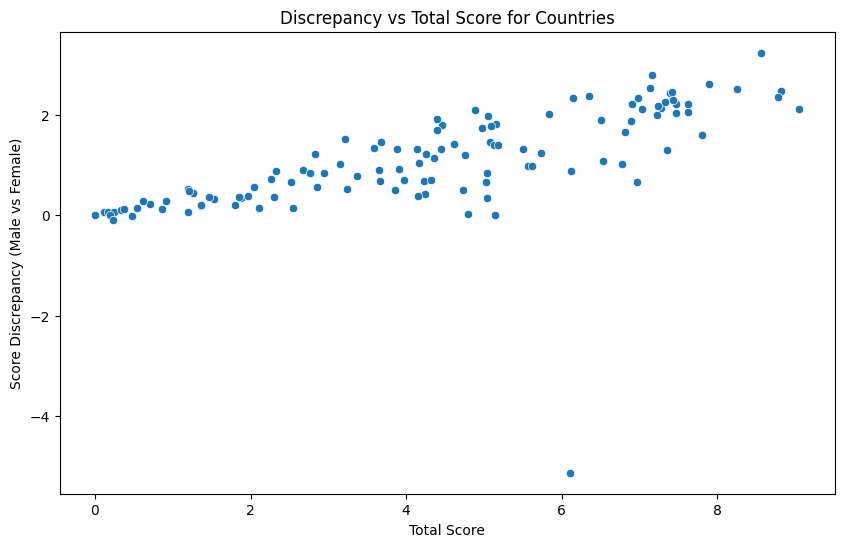

Correlation between Total Score and Score Discrepancy: 0.6610208705150431


In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_pivot, x='Total_Score', y='Score_Discrepancy')
plt.title('Discrepancy vs Total Score for Countries')
plt.xlabel('Total Score')
plt.ylabel('Score Discrepancy (Male vs Female)')
plt.show()

correlation = df_pivot['Total_Score'].corr(df_pivot['Score_Discrepancy'])
print(f"Correlation between Total Score and Score Discrepancy: {correlation}")

Kind of an interesting finding that the higher the health score the more there is interms of discrepency.

In [ ]:
#Question 3
correlation = last_df['GDP per capita (2018)'].corr(last_df['Score'])
print(f"Correlation between GDP (2018) and Healthcare Score: {correlation}")
score_threshold1 = last_df['Score'].quantile(0.25)
gdp_threshold1 = last_df['GDP per capita (2018)'].quantile(0.75)

score_threshold2 = last_df['Score'].quantile(0.75)
gdp_threshold2 = last_df['GDP per capita (2018)'].quantile(0.25)

high_gdp_low_score = last_df[(last_df['GDP per capita (2018)'] > gdp_threshold1) & (last_df['Score'] < score_threshold1)]
low_gdp_high_score = last_df[(last_df['GDP per capita (2018)'] < gdp_threshold2) & (last_df['Score'] > score_threshold2)]

print("High GDP but Low Score Countries:")
print(high_gdp_low_score[['Country_Name', 'GDP per capita (2018)', 'Score']])

print("Low GDP but High Score Countries:")
print(low_gdp_high_score[['Country_Name', 'GDP per capita (2018)', 'Score']])

Correlation between GDP (2018) and Healthcare Score: 0.1830251000503087
High GDP but Low Score Countries:
            Country_Name  GDP per capita (2018)     Score
6                Bahrain              39501.176  1.368575
69                 Qatar             152453.810  1.195160
61                  Oman              50135.402  0.613953
89  United Arab Emirates              74206.484  0.231726
73          Saudi Arabia              50906.484  0.189373
Low GDP but High Score Countries:
Empty DataFrame
Columns: [Country_Name, GDP per capita (2018), Score]
Index: []


             Country_Name     Score  Median Income USD   GDP_PPP
79    Trinidad and Tobago  9.052937             2868.0   31572.0
32                Hungary  8.818943             7684.0   45942.0
35                Ireland  8.771918            14520.0  127623.0
50              Mauritius  8.554500             3832.0   29499.0
25                Finland  8.253780            16332.0   65061.0
..                    ...       ...                ...       ...
68             Seychelles  0.377274             5314.0   32694.0
66  Sao Tome and Principe  0.331809              901.0    6064.0
82   United Arab Emirates  0.231726            24292.0   83903.0
34                   Iraq  0.216064             1951.0   13969.0
44                Lebanon  0.166436             7712.0   12853.0

[85 rows x 4 columns]
Correlation between Median Income and Healthcare Score: 0.42231672546361665
Correlation between purchasing power parity and Healthcare Score: 0.5073036234132502
High median income but Low Score Cou

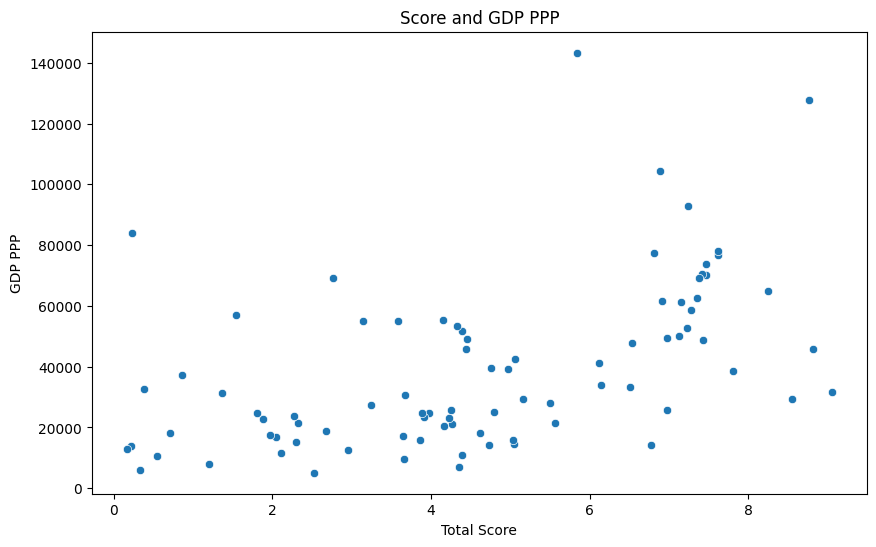

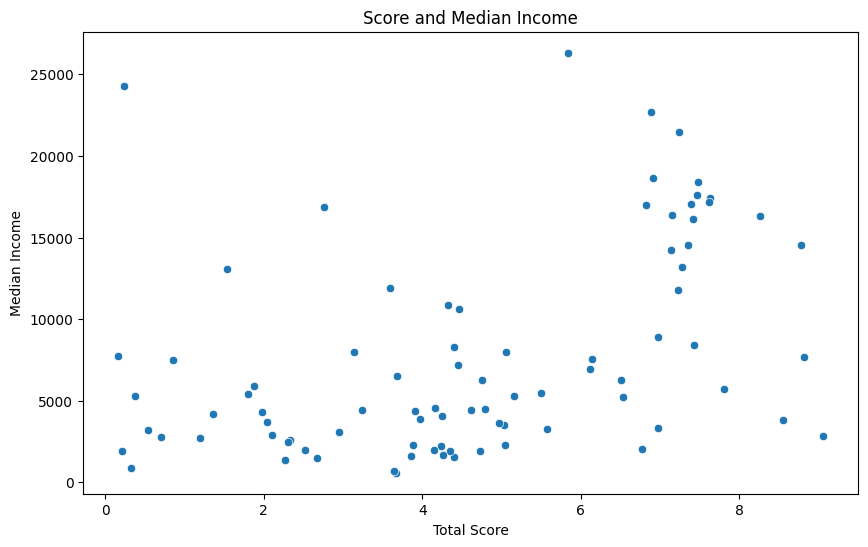

In [ ]:
median_url= 'https://docs.google.com/spreadsheets/d/1ZHHkm3I6cVJ5TVRA4KICYMJfxwb0UNLJ6XmrppPwVGs/export?format=csv'
ppp_df= pd.read_csv(median_url, on_bad_lines='skip', low_memory= False)


final_df = pd.merge(df_all, ppp_df, on='Country_Name', how='inner')
final_df=final_df.sort_values(by='Score',ascending= False)
print(final_df)

correlation2 = final_df['Median Income USD'].corr(final_df['Score'])
print(f"Correlation between Median Income and Healthcare Score: {correlation2}")
correlation3 = final_df['GDP_PPP'].corr(final_df['Score'])
print(f"Correlation between purchasing power parity and Healthcare Score: {correlation3}")
#score_threshold1 = 0.25 score theshold2= 0.75
med_threshold1 = final_df['Median Income USD'].quantile(0.75)
med_threshold2 = final_df['Median Income USD'].quantile(0.25)

ppp_threshold1 = final_df['GDP_PPP'].quantile(0.75)
ppp_threshold2 = final_df['GDP_PPP'].quantile(0.25)

high_median_low_score = final_df[(final_df['Median Income USD'] > med_threshold1) & (final_df['Score'] < score_threshold1)]
low_median_high_score = final_df[(final_df['Median Income USD'] < med_threshold2) & (final_df['Score'] > score_threshold2)]

print("High median income but Low Score Countries:")
print(high_median_low_score[['Country_Name', 'Median Income USD', 'Score']])

print("Low median income but High Score Countries:")
print(low_median_high_score[['Country_Name', 'Median Income USD', 'Score']])


high_ppp_low_score = final_df[(final_df['GDP_PPP'] > med_threshold1) & (final_df['Score'] < score_threshold1)]
low_ppp_high_score = final_df[(final_df['GDP_PPP'] < med_threshold2) & (final_df['Score'] > score_threshold2)]

print("High Purchasing power parity but Low Score Countries:")
print(high_median_low_score[['Country_Name', 'GDP_PPP', 'Score']])

print("Low Purchasing power parity but High Score Countries:")
print(low_median_high_score[['Country_Name', 'GDP_PPP', 'Score']])

plt.figure(figsize=(10,6))
sns.scatterplot(data=final_df, x='Score', y='GDP_PPP')
plt.title('Score and GDP PPP')
plt.xlabel('Total Score')
plt.ylabel('GDP PPP')
plt.show()


plt.figure(figsize=(10,6))
sns.scatterplot(data=final_df, x='Score', y='Median Income USD')
plt.title('Score and Median Income')
plt.xlabel('Total Score')
plt.ylabel('Median Income')
plt.show()


In [ ]:
#EXPAND THIS SECTION TO PRESENT YOUR FINDINGS

**Question 1:**

What countries tend to have a larger discrepency between sexs for their scores? Are the countries usually on the lower or higher end of our overall scores?(Does having a higher score usually mean that the discrepency goes down)

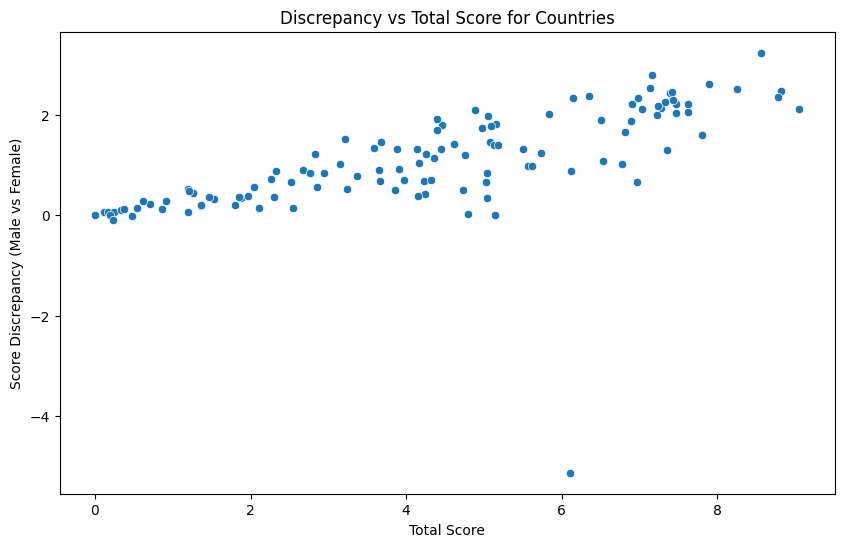

Correlation between Total Score and Score Discrepancy: 0.6610208705150431


In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_pivot, x='Total_Score', y='Score_Discrepancy')
plt.title('Discrepancy vs Total Score for Countries')
plt.xlabel('Total Score')
plt.ylabel('Score Discrepancy (Male vs Female)')
plt.show()

correlation = df_pivot['Total_Score'].corr(df_pivot['Score_Discrepancy'])
print(f"Correlation between Total Score and Score Discrepancy: {correlation}")

We can notice a rather interesting correlation between countries that have a higher score in terms of healthcare having a larger discrepancy when comparing male vs female scores. Other than one very large outlier there is a general trend that countries that proved to score higher tend to also have a larger bias towards male healthcare vs female healthcare.

Although this is an interesting finding off the dataset, the finidng is lacking in a lot of ways such as our arbitrary scoring system that strongly penalizes child mortality and rewards older age. The dataset doesnt specify potential deaths caused during childbirth which can skew the data a little bit(expected) but not to the point we are seeing here. The data used here is deaths per hundred thousands per sex, meaning that the skew can not be contributed to population differences either.

Overall this is a rather interesting find that shows as healthcare improves the biases that women might face also increase.

**Question 2:**

Does Purchasing power parity and median income show a better trend in understanding mortality rate?

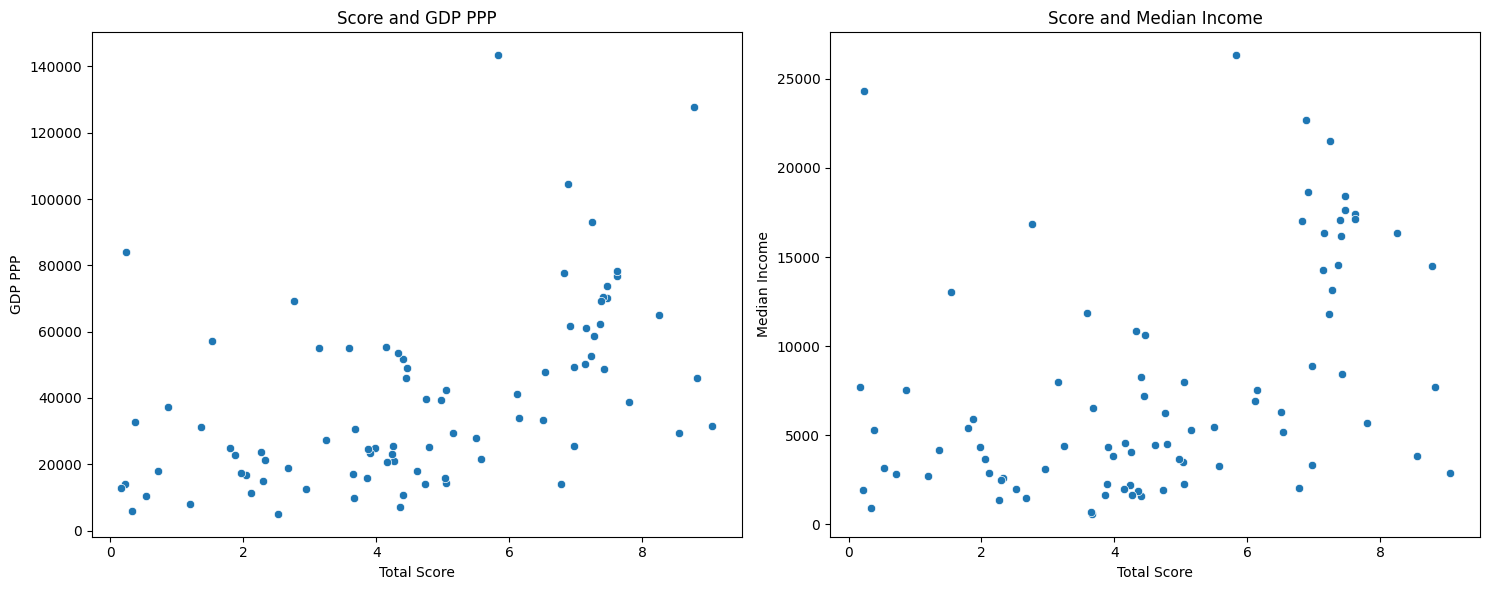

Correlation between Median Income and Healthcare Score: 0.42231672546361665
Correlation between purchasing power parity and Healthcare Score: 0.5073036234132502


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(data=final_df, x='Score', y='GDP_PPP', ax=axes[0])
axes[0].set_title('Score and GDP PPP')
axes[0].set_xlabel('Total Score')
axes[0].set_ylabel('GDP PPP')

sns.scatterplot(data=final_df, x='Score', y='Median Income USD', ax=axes[1])
axes[1].set_title('Score and Median Income')
axes[1].set_xlabel('Total Score')
axes[1].set_ylabel('Median Income')

plt.tight_layout()

plt.show()

correlation2 = final_df['Median Income USD'].corr(final_df['Score'])
print(f"Correlation between Median Income and Healthcare Score: {correlation2}")
correlation3 = final_df['GDP_PPP'].corr(final_df['Score'])
print(f"Correlation between purchasing power parity and Healthcare Score: {correlation3}")

Even though the two scatterplots are extremely similar visually there are still overall differences that can be seen. There is a decently large difference in correlation between the two graphs and we get pointed towards purchasing power parity being a better indicator of health score.


**Question 3:**

If we compare our scores to GDP of the country from 2018 (using pre-covid data) We would most likely see a correlation but are there countries that do not follow the trend. For example high gdp but low score or vise versa.

In [ ]:
print(f"Correlation between GDP (2018) and Healthcare Score: {correlation}")

print("\nHigh GDP but Low Score Countries:")
print(high_gdp_low_score[['Country_Name', 'GDP per capita (2018)', 'Score']].to_string(index=False))

print("\nLow GDP but High Score Countries:")
print(low_gdp_high_score[['Country_Name', 'GDP per capita (2018)', 'Score']].to_string(index=False))

Correlation between GDP (2018) and Healthcare Score: 0.6610208705150431

High GDP but Low Score Countries:
        Country_Name  GDP per capita (2018)    Score
             Bahrain              39501.176 1.368575
               Qatar             152453.810 1.195160
                Oman              50135.402 0.613953
United Arab Emirates              74206.484 0.231726
        Saudi Arabia              50906.484 0.189373

Low GDP but High Score Countries:
Empty DataFrame
Columns: [Country_Name, GDP per capita (2018), Score]
Index: []


There is a rather strong correlation between GDP and health scores. This correlation would put GDP as the best indicator for health scores so far.

We can notice that there are no countries in our datset that had a high score for health but had low GDP which should work with our intuition that having more financial means would also mean that more wealth is available for healthcare overall.

The countries that scored low but had a high GDP was somewhat interesting to find. The countries are all from the same region of the globe being the middle east. We can not determine any attributing factors from the datset alone but it can be associated intuitively (not based off the dataset) to severe wealth disparity where there is high production and wealth skewed towards the top while the bottom 99% are living off way worse.